# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig0820s1"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 400

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(966, 32, 20, 3)
(966, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/400
242/242 [==============================] - 2s 8ms/step - loss: 1.9210 - accuracy: 0.4255
Epoch 2/400
242/242 [==============================] - 2s 8ms/step - loss: 1.1774 - accuracy: 0.6439
Epoch 3/400
242/242 [==============================] - 2s 8ms/step - loss: 0.8318 - accuracy: 0.7484
Epoch 4/400
242/242 [==============================] - 2s 7ms/step - loss: 0.6513 - accuracy: 0.7992
Epoch 5/400
242/242 [==============================] - 2s 8ms/step - loss: 0.5784 - accuracy: 0.8271
Epoch 6/400
242/242 [==============================] - 2s 9ms/step - loss: 0.4886 - accuracy: 0.8530
Epoch 7/400
242/242 [==============================] - 2s 9ms/step - loss: 0.4974 - accuracy: 0.8509: 0s - loss: 0.5052 - accuracy
Epoch 8/400
242/242 [==============================] - 2s 9ms/step - loss: 0.4201 - accuracy: 0.8789
Epoch 9/400
242/242 [==============================] - 2s 9ms/step - loss: 0.3565 - ac

242/242 [==============================] - 3s 11ms/step - loss: 0.0859 - accuracy: 0.9710
Epoch 78/400
242/242 [==============================] - 3s 11ms/step - loss: 0.0677 - accuracy: 0.9772 0s - loss: 0.0686 - accuracy: 0.
Epoch 79/400
242/242 [==============================] - 3s 11ms/step - loss: 0.0770 - accuracy: 0.9783
Epoch 80/400
242/242 [==============================] - 3s 12ms/step - loss: 0.0741 - accuracy: 0.9803
Epoch 81/400
242/242 [==============================] - 3s 11ms/step - loss: 0.0563 - accuracy: 0.9834
Epoch 82/400
242/242 [==============================] - 3s 11ms/step - loss: 0.0661 - accuracy: 0.9865
Epoch 83/400
242/242 [==============================] - 3s 11ms/step - loss: 0.0685 - accuracy: 0.9834
Epoch 84/400
242/242 [==============================] - 3s 12ms/step - loss: 0.0661 - accuracy: 0.9845
Epoch 85/400
242/242 [==============================] - 3s 12ms/step - loss: 0.0715 - accuracy: 0.9752
Epoch 86/400
242/242 [==============================]

242/242 [==============================] - 2s 10ms/step - loss: 0.0489 - accuracy: 0.9886
Epoch 155/400
242/242 [==============================] - 3s 11ms/step - loss: 0.0289 - accuracy: 0.9917
Epoch 156/400
242/242 [==============================] - 2s 10ms/step - loss: 0.0462 - accuracy: 0.9834
Epoch 157/400
242/242 [==============================] - 3s 10ms/step - loss: 0.0472 - accuracy: 0.9865
Epoch 158/400
242/242 [==============================] - 3s 11ms/step - loss: 0.0626 - accuracy: 0.9803
Epoch 159/400
242/242 [==============================] - 3s 11ms/step - loss: 0.0477 - accuracy: 0.9834
Epoch 160/400
242/242 [==============================] - 3s 10ms/step - loss: 0.0231 - accuracy: 0.9917
Epoch 161/400
242/242 [==============================] - 2s 10ms/step - loss: 0.0483 - accuracy: 0.9845
Epoch 162/400
242/242 [==============================] - 3s 10ms/step - loss: 0.0365 - accuracy: 0.9896
Epoch 163/400
242/242 [==============================] - 3s 11ms/step - loss: 

Epoch 232/400
242/242 [==============================] - 3s 11ms/step - loss: 0.0548 - accuracy: 0.9886
Epoch 233/400
242/242 [==============================] - 3s 11ms/step - loss: 0.0249 - accuracy: 0.9938
Epoch 234/400
242/242 [==============================] - 3s 10ms/step - loss: 0.0351 - accuracy: 0.9907
Epoch 235/400
242/242 [==============================] - 3s 11ms/step - loss: 0.0133 - accuracy: 0.9959
Epoch 236/400
242/242 [==============================] - 3s 11ms/step - loss: 0.0368 - accuracy: 0.9907
Epoch 237/400
242/242 [==============================] - 3s 11ms/step - loss: 0.0719 - accuracy: 0.9886
Epoch 238/400
242/242 [==============================] - 3s 11ms/step - loss: 0.0230 - accuracy: 0.9959
Epoch 239/400
242/242 [==============================] - 3s 11ms/step - loss: 0.0413 - accuracy: 0.9928
Epoch 240/400
242/242 [==============================] - 3s 11ms/step - loss: 0.0110 - accuracy: 0.9928
Epoch 241/400
242/242 [==============================] - 3s 11ms

242/242 [==============================] - 2s 10ms/step - loss: 0.0130 - accuracy: 0.9969
Epoch 311/400
242/242 [==============================] - 3s 11ms/step - loss: 0.0418 - accuracy: 0.9917 0s - loss: 0.0230 
Epoch 312/400
242/242 [==============================] - 3s 11ms/step - loss: 0.0061 - accuracy: 0.9979
Epoch 313/400
242/242 [==============================] - 3s 10ms/step - loss: 0.0571 - accuracy: 0.9928
Epoch 314/400
242/242 [==============================] - 3s 10ms/step - loss: 0.0240 - accuracy: 0.9938
Epoch 315/400
242/242 [==============================] - 3s 10ms/step - loss: 0.0162 - accuracy: 0.9969
Epoch 316/400
242/242 [==============================] - 2s 9ms/step - loss: 0.0235 - accuracy: 0.9959
Epoch 317/400
242/242 [==============================] - 2s 9ms/step - loss: 0.0059 - accuracy: 0.9959: 0s - los
Epoch 318/400
242/242 [==============================] - 2s 8ms/step - loss: 0.0126 - accuracy: 0.9948
Epoch 319/400
242/242 [=============================

242/242 [==============================] - 2s 6ms/step - loss: 0.0743 - accuracy: 0.9917
Epoch 389/400
242/242 [==============================] - 1s 6ms/step - loss: 0.0100 - accuracy: 0.9969
Epoch 390/400
242/242 [==============================] - 2s 7ms/step - loss: 0.0497 - accuracy: 0.9896
Epoch 391/400
242/242 [==============================] - 2s 7ms/step - loss: 0.0319 - accuracy: 0.9948
Epoch 392/400
242/242 [==============================] - 2s 7ms/step - loss: 0.0369 - accuracy: 0.9928
Epoch 393/400
242/242 [==============================] - 2s 6ms/step - loss: 0.0152 - accuracy: 0.9969
Epoch 394/400
242/242 [==============================] - 2s 6ms/step - loss: 5.2120e-04 - accuracy: 1.0000
Epoch 395/400
242/242 [==============================] - 2s 7ms/step - loss: 0.0330 - accuracy: 0.9917
Epoch 396/400
242/242 [==============================] - 2s 6ms/step - loss: 0.0338 - accuracy: 0.9938
Epoch 397/400
242/242 [==============================] - 2s 6ms/step - loss: 0.0079

### Learing result
 
* Visualization of the training and validation results

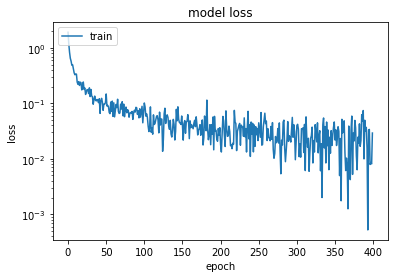

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


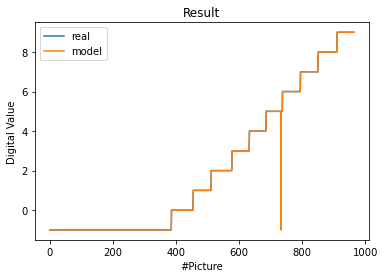

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

765980

In [8]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 20, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
converter2.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter2.inference_input_type = tf.int8  # or tf.uint8
converter2.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

202688

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


ziffer_sortiert_resize/5\Ziffer_5_0018.jpg 5 NaN


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.